In [0]:
import pandas as pd
import numpy as np
import gc
import os
import glob
import re
from collections import defaultdict
import regex
# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
import pyLDAvis.gensim

import networkx as nx
import nltk
from nltk.util import ngrams
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt

# LDA stuff
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

/usr/local/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:281: DeprecationWarning:

Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.



/usr/local/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



In [0]:
PATH = "/social_bias_data/russian-troll-tweets/"

In [0]:
filenames = glob.glob(os.path.join(PATH, "*.csv"))

In [0]:
for file in filenames:
    print("Preprocessing {}".format(file))
df = pd.concat((pd.read_csv(f) for f in filenames))

Preprocessing /social_bias_data/russian-troll-tweets/IRAhandle_tweets_9.csv
Preprocessing /social_bias_data/russian-troll-tweets/IRAhandle_tweets_7.csv
Preprocessing /social_bias_data/russian-troll-tweets/IRAhandle_tweets_5.csv
Preprocessing /social_bias_data/russian-troll-tweets/IRAhandle_tweets_8.csv
Preprocessing /social_bias_data/russian-troll-tweets/IRAhandle_tweets_3.csv
Preprocessing /social_bias_data/russian-troll-tweets/IRAhandle_tweets_1.csv
Preprocessing /social_bias_data/russian-troll-tweets/IRAhandle_tweets_4.csv
Preprocessing /social_bias_data/russian-troll-tweets/IRAhandle_tweets_6.csv
Preprocessing /social_bias_data/russian-troll-tweets/IRAhandle_tweets_2.csv


In [0]:
print("File shape after concatenation {}".format(df.shape))

File shape after concatenation (2973371, 15)


# Basic View Of The Data

In [0]:
df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,1.513801e+09,YOUJUSTCTRLC,I went to Homegoods to get a table runner and ...,United States,English,1/8/2017 1:57,1/8/2017 1:57,2655,2724,3015,RETWEET,left,0,1,LeftTroll
1,1.513801e+09,YOUJUSTCTRLC,"The education of the masses, which should begi...",United States,English,1/8/2017 1:57,1/8/2017 1:57,2655,2724,3014,RETWEET,left,0,1,LeftTroll
2,1.513801e+09,YOUJUSTCTRLC,#SciFiSunday: Interview With Fantasy Writer Ab...,United States,English,1/8/2017 20:02,1/8/2017 20:02,2657,2725,3024,RETWEET,left,0,1,LeftTroll
3,1.513801e+09,YOUJUSTCTRLC,"""The original purpose of the plantation was to...",United States,English,1/8/2017 20:02,1/8/2017 20:02,2657,2725,3021,RETWEET,left,0,1,LeftTroll
4,1.513801e+09,YOUJUSTCTRLC,Begging for her back R&amp;B &gt; Fuck that bi...,United States,English,1/8/2017 7:57,1/8/2017 7:57,2657,2723,3017,RETWEET,left,0,1,LeftTroll


# Our Target Account Category Types

In [0]:
df["account_category"].unique()

array(['LeftTroll', 'NonEnglish', 'Unknown', 'RightTroll', 'Fearmonger',
       'NewsFeed', 'HashtagGamer', 'Commercial'], dtype=object)

In [0]:
df.describe(include="all")

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
count,2.973367e+06,2973371,2973370,2964528,2973371,2973371,2973371,2.973371e+06,2.973371e+06,2.973371e+06,1310946,2973008,2.973371e+06,2.973371e+06,2973371
unique,NaN,2848,2365942,36,56,896684,906316,NaN,NaN,NaN,2,20,NaN,NaN,8
top,NaN,EXQUOTE,В городе Сочи. Олимпиада – праздник или стихий...,United States,English,8/16/2017 1:29,3/22/2016 17:35,NaN,NaN,NaN,RETWEET,Russian,NaN,NaN,NonEnglish
freq,NaN,59652,670,2055882,2128963,202,1333,NaN,NaN,NaN,1270702,721191,NaN,NaN,837725
mean,1.296128e+17,NaN,NaN,NaN,NaN,NaN,NaN,3.433524e+03,7.018913e+03,1.049756e+04,NaN,NaN,2.078735e-01,4.408955e-01,NaN
std,3.036341e+17,NaN,NaN,NaN,NaN,NaN,NaN,5.609881e+03,1.458463e+04,1.768729e+04,NaN,NaN,4.057859e-01,4.964945e-01,NaN
min,3.497640e+07,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,-1.000000e+00,-1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,1.930748e+09,NaN,NaN,NaN,NaN,NaN,NaN,3.270000e+02,3.200000e+02,1.787000e+03,NaN,NaN,0.000000e+00,0.000000e+00,NaN
50%,2.581835e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.499000e+03,1.274000e+03,4.333000e+03,NaN,NaN,0.000000e+00,0.000000e+00,NaN
75%,3.254274e+09,NaN,NaN,NaN,NaN,NaN,NaN,4.730000e+03,1.060000e+04,1.234100e+04,NaN,NaN,0.000000e+00,1.000000e+00,NaN


In [0]:
df["content"].nunique()

2365942

In [0]:
df["content"].count() # It seems we have a lot of duplicate twitter messages

2973370

In [0]:
print("Number of unique twitter accounts {}".format(df["author"].nunique()))

Number of unique twitter accounts 2848


# Top Twitter Authors

In [0]:
df.author.value_counts().head(20)

EXQUOTE            59652
SCREAMYMONKEY      44041
WORLDNEWSPOLI      36974
AMELIEBALDWIN      35371
TODAYPITTSBURGH    33602
SPECIALAFFAIR      32588
SEATTLE_POST       30800
FINDDIET           29038
KANSASDAILYNEWS    28890
ROOMOFRUMOR        28360
DAILYSANFRAN       28076
WORLDOFHASHTAGS    23724
COVFEFENATIONUS    23544
POLITICS_T0DAY     23034
RIAFANRU           22886
JENN_ABRAMS        22861
CHICAGODAILYNEW    22236
FUNDDIET           20192
BERLINBOTE         19748
CHESPLAYSCHESS     19216
Name: author, dtype: int64

# Good, it seems that top twitter accounts are mainly named/related to popular news sources e.g. SEATTLE_POST, CHICAGODAILYNEW etc. We will dig more into this later 
# Lets see the author twitting frequence under normalized form, for scratch intuition about the distribution

In [0]:
df.author.value_counts(normalize=True).head(50)

EXQUOTE            0.020062
SCREAMYMONKEY      0.014812
WORLDNEWSPOLI      0.012435
AMELIEBALDWIN      0.011896
TODAYPITTSBURGH    0.011301
SPECIALAFFAIR      0.010960
SEATTLE_POST       0.010359
FINDDIET           0.009766
KANSASDAILYNEWS    0.009716
ROOMOFRUMOR        0.009538
DAILYSANFRAN       0.009442
WORLDOFHASHTAGS    0.007979
COVFEFENATIONUS    0.007918
POLITICS_T0DAY     0.007747
RIAFANRU           0.007697
JENN_ABRAMS        0.007689
CHICAGODAILYNEW    0.007478
FUNDDIET           0.006791
BERLINBOTE         0.006642
CHESPLAYSCHESS     0.006463
TODAYNYCITY        0.006233
ONLINECLEVELAND    0.005955
HYDDROX            0.005856
OLD_NEW_POLICY     0.005185
TODAYINSYRIA       0.005180
NEWORLEANSON       0.005010
ARM_2_ALAN         0.004951
CHRIXMORGAN        0.004946
DAILYSANDIEGO      0.004848
DAILYLOSANGELES    0.004761
DETROITDAILYNEW    0.004747
TODAYMIAMI         0.004736
PHOENIXDAILYNEW    0.004640
PHILADELPHIAON     0.004501
CANNONSHER         0.004379
DANAGEEZUS         0

# Top twitter accounts are good indicator, but there is a case of many 1-2-3 twitter posts per user, these groups are also good for further investigation

In [0]:
(df.author.value_counts()==1).sum()

40

In [0]:
(df.author.value_counts()==2).sum()

30

In [0]:
(df.author.value_counts()==3).sum()

62

In [0]:
(df.author.value_counts()==4).sum()

23

In [0]:
(df.author.value_counts()==5).sum()

27

# Lets take a basic overview of the troll language frequency

In [0]:
df.language.value_counts()

English                2128963
Russian                 624124
German                   87171
Ukrainian                39361
Italian                  18254
Serbian                   9615
Uzbek                     9491
Bulgarian                 9458
LANGUAGE UNDEFINED        8325
Arabic                    7595
Macedonian                5260
French                    4572
Spanish                   3145
Norwegian                 2252
Farsi (Persian)           1685
Romanian                  1631
Dutch                     1167
Swedish                   1021
Vietnamese                 990
Estonian                   771
Japanese                   766
Catalan                    590
Finnish                    581
Albanian                   572
Croatian                   546
Icelandic                  499
Pushto                     488
Portuguese                 465
Turkish                    445
Lithuanian                 417
Polish                     386
Somali                     277
Slovak  

In [0]:
df[df["language"] == "Bulgarian"]["content"].head(20)

3387    Ассанж разоблачил заговор Google и Клинтон htt...
3621    «Столкновение турок и ИГ похоже на имитацию»  ...
3771    «Уфа» — «Зенит»: гол Данни в ворота «Уфы» http...
3826    Омичи опубликовали видео, как сын депутата вре...
4075    Япония поддержала усиление мер по защите берег...
4105    ФОТОРЕПОРТАЖ. Мемориал погибшим на «майдане» в...
4127    Давутоглу представит Турцию на саммите с ЕС по...
4343    Имам застрелен на Ставрополье  http://t.co/tN7...
4406                  Зато честно! http://t.co/4FJ4lumRMU
4628       Право на безучастие \| https://t.co/14C32V7DIt
4703    '@Kozlovacautaret Вас как всегда приятно читат...
4720    СМИ: китайская компания приобретет 30 самолето...
4743    Ах, да. Завтра еще и олимпиада по английскому ...
4752    Добавлена новая акция для Планета Спорт: : Ски...
4757                 '@Popovalerverimu ммм)) так клёво))'
4814    На Computex представлена карта памяти microSD ...
4824                    '@AebnlfaoAnna Супер! Спасибо :0'
4833    Месси 

# It looks like Bulgarian is actually Russian :)

# We should expect other such misscategorizations in the data

In [0]:
df.account_category.value_counts(normalize=True)

NonEnglish      0.281743
RightTroll      0.241842
NewsFeed        0.201554
LeftTroll       0.143881
HashtagGamer    0.081331
Commercial      0.041227
Unknown         0.004677
Fearmonger      0.003747
Name: account_category, dtype: float64

In [0]:
df.isnull().sum().sort_values(ascending = False)

post_type             1662425
region                   8843
account_type              363
external_author_id          4
content                     1
account_category            0
retweet                     0
new_june_2018               0
updates                     0
followers                   0
following                   0
harvested_date              0
publish_date                0
language                    0
author                      0
dtype: int64

# ~40% are NaNs in post_type section

# Period Interval of Twitting¶

In [0]:
start_date_tweet = df['publish_date'].min()
end_date_tweet = df['publish_date'].max()

In [0]:
print("First twitter message {}".format(start_date_tweet))
print("Last twitter message {}".format(end_date_tweet))

First twitter message 1/1/2013 16:16
Last twitter message 9/9/2017 9:51


In [0]:
df['publish_date'] = df['publish_date'].apply(lambda x : str(x))
df['publish_date'] = pd.to_datetime(df['publish_date'])
df['publish_date'] = pd.to_datetime(df['publish_date'].dt.date)

In [0]:
df['publish_date'].head(10)

0   2017-01-08
1   2017-01-08
2   2017-01-08
3   2017-01-08
4   2017-01-08
5   2017-01-08
6   2017-01-09
7   2017-01-09
8   2017-01-09
9   2017-01-09
Name: publish_date, dtype: datetime64[ns]

In [0]:
# Count the number of times a date appears in the dataset and convert to dataframe
tweet_trend = pd.DataFrame(df['publish_date'].value_counts())

# index is date, columns indicate tweet count on that day
tweet_trend.columns = ['tweet_count']

# sort the dataframe by the dates to have them in order
tweet_trend.sort_index(ascending = True, inplace = True)

Text(0,0.5,'Tweet Count')

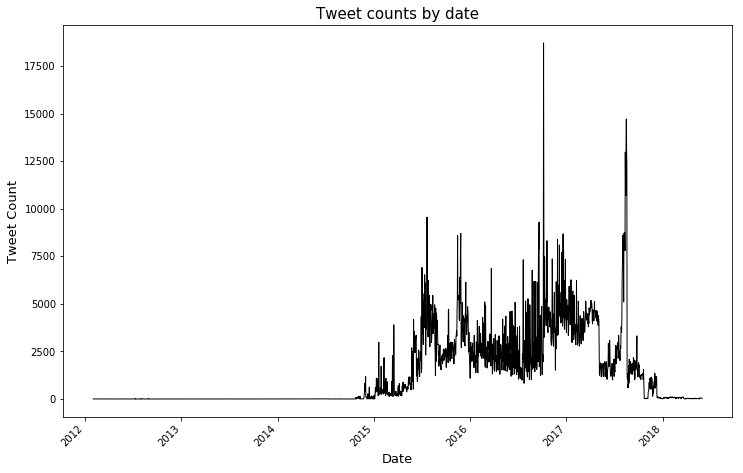

In [0]:
tweet_trend['tweet_count'].plot(linestyle = "-", figsize = (12,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

In [0]:
# Important dates for example in Trump's campaign
dates_list = ['2015-06-16', '2015-12-07', '2016-02-01',
              '2016-03-01', '2016-03-03', '2016-03-11',
              '2016-05-03', '2016-05-26', '2016-06-20', 
              '2016-07-15', '2016-07-21', '2016-08-17',
              '2016-09-01', '2016-10-07', '2016-11-08']

#TODO Extract Hillary's and other important Political Events ( especially for 2017 & 2018)
#TODO Extract Important Dates mentioned in all popular news sources

# create a series of these dates.
important_dates = pd.Series(pd.to_datetime(dates_list))

# add columns to identify important events, and mark a 0 or 1.
tweet_trend['Important Events'] = False
tweet_trend.loc[important_dates, 'Important Events'] = True
tweet_trend['values'] = 0
tweet_trend.loc[important_dates, 'values'] = 1

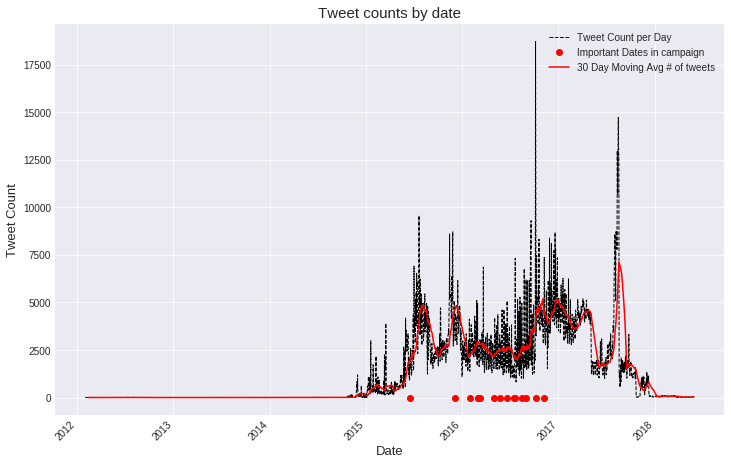

In [0]:
# plot the line chart for trend, a monthly average of tweet counts and add red dots to 
# mark important events.
plt.style.use('seaborn-darkgrid')
tweet_trend['tweet_count'].plot(linestyle = "--", 
                                figsize = (12,8), rot = 45, 
                                color = 'k',
                                label = 'Tweet Count per Day',
                               linewidth = 1)

# plot dots for where values in the tweet_trend df are 1
plt.plot(tweet_trend[tweet_trend['Important Events'] == True].index.values,
         tweet_trend.loc[tweet_trend['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none',
        label = 'Important Dates in campaign')

# Lets add a 30 day moving average on top to view the trend! Min_periods tells rolling() to
# use 10 points if 30 not available!
plt.plot(tweet_trend['tweet_count'].rolling(window = 30, min_periods = 10).mean(), 
         color = 'r', 
         label = '30 Day Moving Avg # of tweets')
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)
plt.legend(loc = 'best')

In [0]:
# Calculate the percentage change in tweet counts
tweet_trend['Pct_Chg_tweets'] = tweet_trend['tweet_count'].pct_change()*100

# Lets see values only for the important dates. This Pct_Chg_tweets shows us the percentage
# change in tweets for the day of the event versus the previous day!
tweet_trend.loc[tweet_trend['values'] == 1,['tweet_count', 'Pct_Chg_tweets']]

,tweet_count,Pct_Chg_tweets
2015-06-16,944,2.720348
2015-12-07,4376,45.672437
2016-02-01,2851,106.894049
2016-03-01,2353,-52.252435
2016-03-03,2217,7.360775
2016-03-11,2599,-10.224525
2016-05-03,2643,20.027248
2016-05-26,1696,-33.464104
2016-06-20,5082,171.040000
2016-07-15,1619,19.660015


In [0]:
# Twitter hashtag extraction based on heuristics and regular expressions
def extract_hashtags(tweet):
    '''Provide a tweet and extract hashtags from it'''
    hashtags_only = []
    if len(re.findall("(#[^#\s]+)", tweet)) > 0:
        hashtags_only.append(re.findall("(#[^#\s]+)", tweet))
    else:
        hashtags_only.append(["0"])
    return hashtags_only[0]
    #return hashtags_only

<input>:5: DeprecationWarning:

invalid escape sequence \s

<input>:6: DeprecationWarning:

invalid escape sequence \s

<input>:5: DeprecationWarning:

invalid escape sequence \s

<input>:6: DeprecationWarning:

invalid escape sequence \s

<input>:5: DeprecationWarning:

invalid escape sequence \s

<input>:6: DeprecationWarning:

invalid escape sequence \s

<ipython-input-38-33ad0fcf0fc7>:5: DeprecationWarning:

invalid escape sequence \s

<ipython-input-38-33ad0fcf0fc7>:6: DeprecationWarning:

invalid escape sequence \s



In [0]:
df['content'] = df['content'].apply(lambda x : str(x))

In [0]:
df['tweet_hashtags'] = df['content'].apply(lambda x : extract_hashtags(x))

In [0]:
hash_tags_list = df['tweet_hashtags'].tolist()

In [0]:
cleaned_hashtags = []
for i in hash_tags_list: # Only 10k tweets ( for now )
    for j in i:
        cleaned_hashtags.append(j)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_hashtag_series = pd.Series(cleaned_hashtags)
hashtag_counts = cleaned_hashtag_series.value_counts()

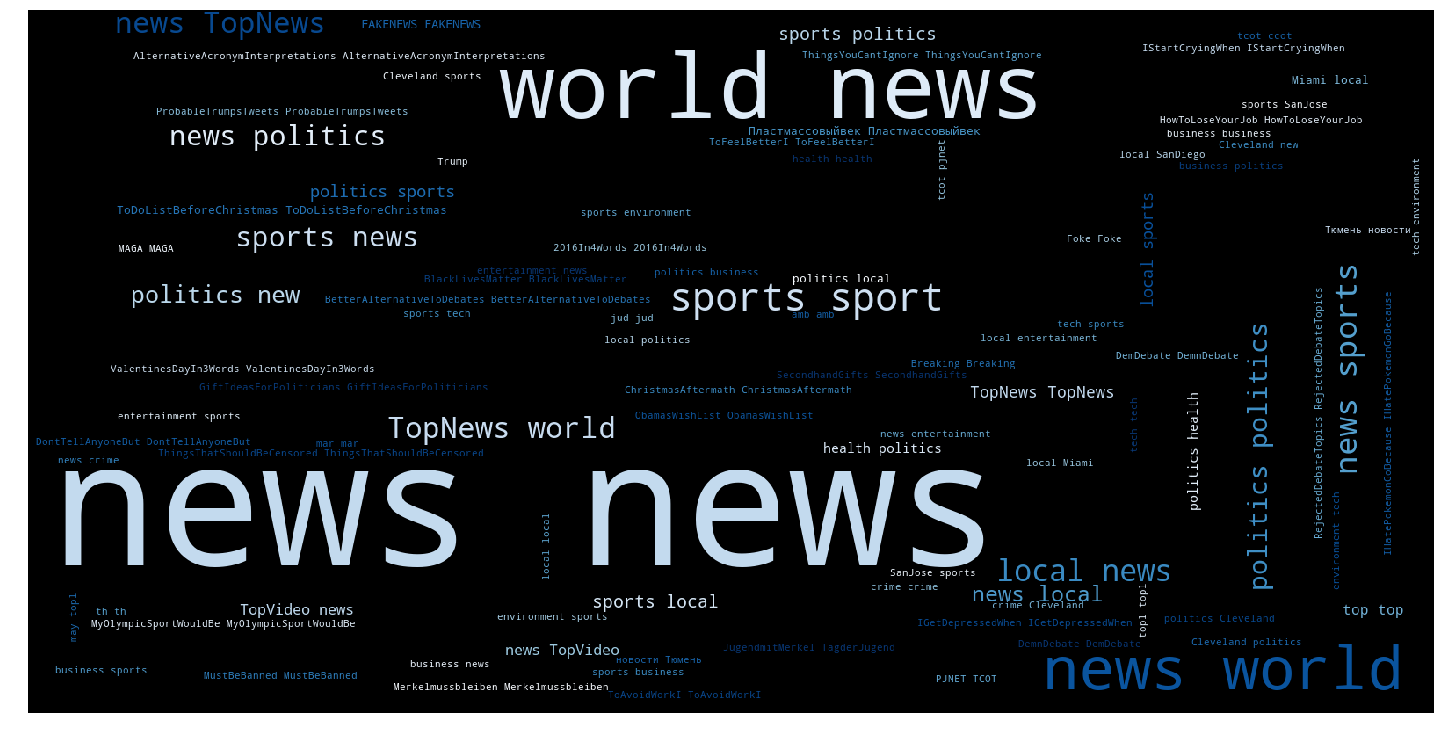

In [0]:
# Get hashtag terms from the series and convert to list
hashes = cleaned_hashtag_series.values
hashes = hashes.tolist()

# convert list to one string with all the words
hashes_words = " ".join(hashes)

# generate the wordcloud. the max_words argument controls the number of words on the cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width= 1600, height = 800, 
                      relative_scaling = 1.0, 
                      colormap = "Blues",
                     max_words = 100).generate(hashes_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Text(0,0.5,'Hashtags')

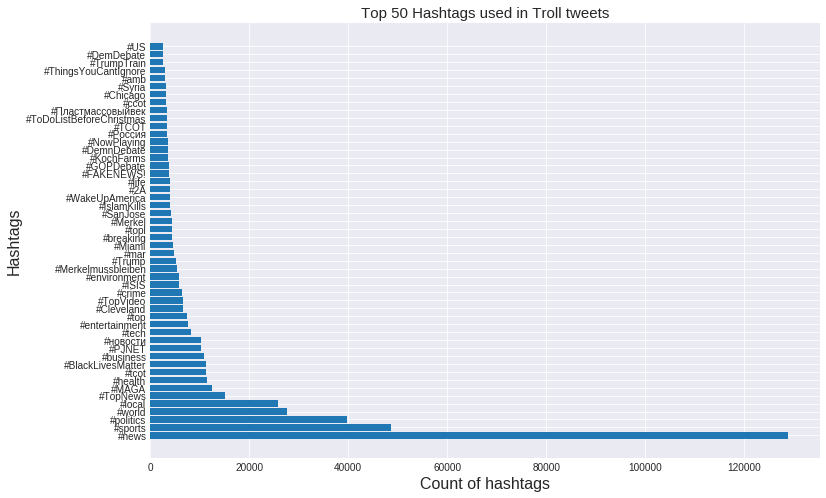

In [0]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (12,8))
plt.barh(y = hashtag_counts[1:51].index.values, width = hashtag_counts[1:51])
plt.title("Top 50 Hashtags used in Troll tweets", fontsize = 15)
plt.xlabel('Count of hashtags', fontsize = 16)
plt.ylabel('Hashtags', fontsize = 16)

In [0]:
# Create a dataframe with just the date and the hashtags in the tweet on that date
hashtag_date_df = df[['publish_date', 'tweet_hashtags']]
hashtag_date_df = hashtag_date_df.reset_index(drop = True)

# extract a list of hashtags from the dataframe
all_hashtags = hashtag_date_df['tweet_hashtags'].tolist()

hashtag_date_df.head()

,publish_date,tweet_hashtags
0,2017-01-08,[0]
1,2017-01-08,[0]
2,2017-01-08,[#SciFiSunday:]
3,2017-01-08,[0]
4,2017-01-08,[0]


In [0]:
# For the top 20 hashtags, lets calculate how many times that appears against each date!
count_dict = {}
for i in hashtag_counts.index.values[1:21]:
    count_hash = []
    for j in all_hashtags:
        count_hash.append(j.count(i))
    count_dict[i] = count_hash

In [0]:
# create a dataframe from the hashtags
hashtag_count_df = pd.DataFrame(count_dict)

# concatenate this dataframe with the hashtag_count_df
hashtag_count_df = pd.concat([hashtag_date_df, hashtag_count_df], axis = 1)

In [0]:
hashtag_count_df.head()

,publish_date,tweet_hashtags,#news,#sports,#politics,#world,#local,#TopNews,#MAGA,#health,...,#business,#PJNET,#новости,#tech,#entertainment,#top,#Cleveland,#TopVideo,#crime,#ISIS
0,2017-01-08,[0],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-08,[0],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-08,[#SciFiSunday:],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-08,[0],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-08,[0],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Checking content unicode script distribution

In [0]:
script_list = [
    r'\p{Arabic}', r'\p{Armenian}', r'\p{Bengali}', r'\p{Bopomofo}', r'\p{Braille}',
    r'\p{Buhid}', r'\p{Canadian_Aboriginal}', r'\p{Cherokee}', r'\p{Cyrillic}',
    r'\p{Devanagari}', r'\p{Ethiopic}', r'\p{Georgian}', r'\p{Greek}', r'\p{Gujarati}',
    r'\p{Gurmukhi}', r'\p{Han}', r'\p{Hangul}', r'\p{Hanunoo}', r'\p{Hebrew}', r'\p{Hiragana}',
    r'\p{Inherited}', r'\p{Kannada}', r'\p{Katakana}', r'\p{Khmer}', r'\p{Lao}', r'\p{Latin}',
    r'\p{Limbu}', r'\p{Malayalam}', r'\p{Mongolian}', r'\p{Myanmar}', r'\p{Ogham}', r'\p{Oriya}',
    r'\p{Runic}', r'\p{Sinhala}', r'\p{Syriac}', r'\p{Tagalog}', r'\p{Tagbanwa}',
    r'\p{TaiLe}', r'\p{Tamil}', r'\p{Telugu}', r'\p{Thaana}', r'\p{Thai}', r'\p{Tibetan}',
    r'\p{Yi}', r'\p{Common}'
]

In [0]:
df["content"] = df["content"].apply(lambda x : str(x))

In [0]:
# Working over only 10k entities
df = df[:10001]

In [0]:
script_occ = pd.DataFrame(
    [regex.sub(r'\\p\{(.+)\}', r'\g<1>', reg) for reg in script_list],
    columns=["script"]
)
script_occ["content"] = [
    df["content"].apply(lambda x: len(regex.findall(reg, x))).sum() for reg in script_list
]

In [0]:
script_occ["twitter_docs"] = [
    (df["content"].apply(lambda x: len(regex.findall(reg, x))) > 0).sum() for reg in script_list
]

In [0]:
from bokeh.core.properties import value
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from math import pi

output_notebook()

Loading BokehJS ...

In [0]:
script_occ.sort_values(by="content", ascending=False, inplace=True)

scripts = list(script_occ.script.values)
dataset = ["content"]

colors = ["#c9d9d3"]

data = {
    'scripts' : scripts,
    'content': list(np.log1p(script_occ.content.values)),
    'real_trn_occ': list(script_occ.content.values),
}

source = ColumnDataSource(data=data)

hover = HoverTool(tooltips=[
    ("Script", "@scripts"),
    ("Content occurence", "@real_trn_occ")
])
p = figure(x_range=scripts, plot_height=500, plot_width=850, title="Unicode Script Categories Occurence",
           toolbar_location=None, tools=[hover])

p.vbar_stack(dataset, x='scripts', width=0.9, color=colors, source=source,
             legend=[value(x) for x in dataset])

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.xaxis.major_label_orientation = pi/3
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"
show(p)

In [0]:
#to seperate sentenses into words
def preprocess(comment):
    """
    Function to build tokenized texts from input comment
    """
    return gensim.utils.simple_preprocess(comment, deacc=True, min_len=3)

In [0]:
all_text=df["content"].apply(lambda x : preprocess(x))

In [0]:
dictionary = Dictionary(all_text)
corpus = [dictionary.doc2bow(text) for text in all_text]

In [0]:
print("Total number of tweets:",len(all_text))

Total number of tweets: 10001


In [0]:
bigram = gensim.models.Phrases(all_text)

In [0]:
bigram[all_text.iloc[10]]

/usr/local/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



['trying',
 'get',
 'plays',
 'now',
 'listen',
 'badadviceshow',
 'where',
 'your',
 'friend',
 'https',
 'mnoymwffes']

In [0]:
ldamodel = LdaModel(corpus=corpus, num_topics=15, id2word=dictionary)

In [0]:
pyLDAvis.enable_notebook()

In [0]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.149364  0.128791       1        1  17.581987
6      0.089518  0.117487       2        1  10.886192
8      0.173969  0.101583       3        1  10.257089
1     -0.077217 -0.016466       4        1   7.366834
9     -0.074128 -0.019222       5        1   7.242404
12    -0.025955  0.014050       6        1   5.833086
4     -0.080592 -0.016259       7        1   5.340399
11    -0.037532 -0.003042       8        1   5.186562
7     -0.062733 -0.017285       9        1   4.839066
13     0.240229 -0.231084      10        1   4.818865
14    -0.066482 -0.006000      11        1   4.259601
0     -0.060453 -0.012490      12        1   4.153577
5     -0.044079 -0.020653      13        1   4.116636
10    -0.067972 -0.008001      14        1   4.112018
3     -0.055935 -0.011413      15        1   4.005695, topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
33281  Default  2864.000000           дворе  2864.000000  30.0000  30.0000
25569  Default  1258.000000          донецк  1258.000000  29.0000  29.0000
40035  Default  1495.000000           sdyef  1495.000000  28.0000  28.0000
27     Default  6206.000000           https  6206.000000  27.0000  27.0000
3059   Default  1083.000000            http  1083.000000  26.0000  26.0000
12553  Default   358.000000             что   358.000000  25.0000  25.0000
46     Default   251.000000             you   251.000000  24.0000  24.0000
20     Default   456.000000             the   456.000000  23.0000  23.0000
12700  Default   188.000000             это   188.000000  22.0000  22.0000
12729  Default   215.000000             для   215.000000  21.0000  21.0000
2879   Default    81.000000           apple    81.000000  20.0000  20.0000
14899  Default   124.000000         спасибо   124.000000  19.0000  19.0000
12842  Default   131.000000             все   131.000000  18.0000  18.0000
12806  Default   182.000000          россии   182.000000  17.0000  17.0000
12823  Default   197.000000             как   197.000000  16.0000  16.0000
2551   Default    49.000000             nom    49.000000  15.0000  15.0000
13350  Default    86.000000             уже    86.000000  14.0000  14.0000
13576  Default   104.000000             вот   104.000000  13.0000  13.0000
1      Default   208.000000             and   208.000000  12.0000  12.0000
12723  Default   138.000000             сша   138.000000  11.0000  11.0000
17270  Default    74.000000          выборы    74.000000  10.0000  10.0000
13341  Default    84.000000            меня    84.000000   9.0000   9.0000
1002   Default    37.000000           photo    37.000000   8.0000   8.0000
12577  Default   125.000000           видео   125.000000   7.0000   7.0000
12717  Default   106.000000           будет   106.000000   6.0000   6.0000
13928  Default    65.000000           очень    65.000000   5.0000   5.0000
13604  Default    73.000000             так    73.000000   4.0000   4.0000
35     Default   155.000000             for   155.000000   3.0000   3.0000
13349  Default    85.000000          только    85.000000   2.0000   2.0000
1976   Default    39.000000            note    39.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
36769  Topic15     2.714502            jbka     3.702069   2.9072  -7.4275
37113  Topic15     2.714502            bzol     3.702070   2.9072  -7.4275
36190  Topic15     2.714500          eoqnhs     3.702069   2.9072  -7.4275
35986  Topic15     2.714500             cnt     3.702069   2.9072  -7.4275
35987  Topic15     2.714500          mtlhpa     3.702069   2.9072  -7.4275
11150  Topic15     2.827482         returns     3.870845   2.9034  -7.3867
2362   Topic15     4.343095          dreams     5.970068   2.8993  -6.9575
17570  Topic15     5.407329       милли

# Trolls stylometry to category_type¶

In [0]:
df['total_length'] = df['content'].apply(len)
df['capitals'] = df['content'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
df['num_exclamation_marks'] = df['content'].apply(lambda comment: comment.count('!'))
df['num_question_marks'] = df['content'].apply(lambda comment: comment.count('?'))
df['num_punctuation'] = df['content'].apply(
    lambda comment: sum(comment.count(w) for w in '.,;:'))
df['num_symbols'] = df['content'].apply(
    lambda comment: sum(comment.count(w) for w in '*&$%'))
df['num_words'] = df['content'].apply(lambda comment: len(comment.split()))
df['num_unique_words'] = df['content'].apply(
    lambda comment: len(set(w for w in comment.split())))
df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
df['num_smilies'] = df['content'].apply(
    lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [0]:
stylometry_features = ['total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks',
            'num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words',
            'words_vs_unique', 'num_smilies', 'num_symbols']
columns = ['account_category_encoding']


In [0]:
df[stylometry_features].head(10)

,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_words,num_unique_words,words_vs_unique,num_smilies,num_symbols
0,97,2,0.020619,0,0,0,21,17,0.809524,0,0
1,106,1,0.009434,0,0,3,15,15,1.000000,0,0
2,104,16,0.153846,0,0,5,9,9,1.000000,0,0
3,135,1,0.007407,0,0,3,27,26,0.962963,0,0
4,57,6,0.105263,0,0,3,10,9,0.900000,0,3
5,103,1,0.009709,0,1,3,15,14,0.933333,0,0
6,97,7,0.072165,0,1,0,17,17,1.000000,0,0
7,118,7,0.059322,0,0,4,18,16,0.888889,0,0
8,110,14,0.127273,1,0,3,15,15,1.000000,0,0
9,130,9,0.069231,0,0,5,14,14,1.000000,0,0


In [0]:
# We need this for correlation check, because 'account_category' is str

df['account_category_encoding'] = df['account_category'].astype('category').cat.codes


In [0]:
rows = [{c:df[f].corr(df[c]) for c in columns} for f in stylometry_features]
df_correlations = pd.DataFrame(rows, index=stylometry_features)

In [0]:
df_correlations

,account_category_encoding
total_length,-0.041045
capitals,-0.000289
caps_vs_length,0.004288
num_exclamation_marks,-0.031838
num_question_marks,-0.077777
num_punctuation,0.012473
num_words,-0.241645
num_unique_words,-0.228872
words_vs_unique,0.174085
num_smilies,0.005395


In [0]:
data = [go.Bar(
            x = df.account_category.unique(),
            y = df.account_category.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = df.account_category.value_counts().values
                        ),
            text='Text entries attributed to Troll Type'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [0]:
grouped_df = df.groupby('account_category')
for name, group in grouped_df:
    print("Troll Type : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["content"])
        cnt += 1
        if cnt == 7:
            break
    print("\n")

Troll Type :  LeftTroll
I went to Homegoods to get a table runner and almost left with an area rug and no table runner ��
The education of the masses, which should begin locally, is foundational to building stronger communities.
#SciFiSunday: Interview With Fantasy Writer Abiola Bello https://t.co/beT75CR0jC https://t.co/GcseXbdmyZ
"The original purpose of the plantation was to grow cotton but we can't say for sure if slaves were on it" maaan if you don't get tf...
Begging for her back R&amp;B &gt; Fuck that bitch R&amp;B
had toni braxton/jim jackson/jason kidd/jamal mashburn happened in the Twitter era? oh god the jokes...
Can somebody tweet out the iTunes link for my podcast #BadAdviceShow? I have an android (Shut up)


Troll Type :  NonEnglish
Йозеф Блаттер, отстраненный от футбольной деятельности, заявил, что не сдастся без борьбы  http://t.co/nxPfAugDIY
Путин: операция РФ в Сирии - не спонтанные действия, а исполнение намеченных ранее планов  http://t.co/srI6Nk4xhT
#Путин в эксклю

In [0]:
def generate_ngrams(text, n=2):
    words = text.split()
    iterations = len(words) - n + 1
    for i in range(iterations):
       yield words[i:i + n]

In [0]:
ngrams = {}
for text in df[df.account_category=="RightTroll"]['content']:
        for ngram in generate_ngrams(text, 3):
            ngram = ' '.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

ngrams_left_troll_df = pd.DataFrame.from_dict(ngrams, orient='index')
ngrams_left_troll_df.columns = ['count']
ngrams_left_troll_df['troll_type'] = 'Right Troll'
ngrams_left_troll_df.reset_index(level=0, inplace=True)

In [0]:
ngrams_left_troll_df.sort_values(by='count', ascending=False).head(20)

,index,count,troll_type
554,of a Nation,3,Right Troll
553,Birth of a,3,Right Troll
168,Operation Christmas Child,3,Right Troll
420,sign the #petition!,2,Right Troll
799,to do about,2,Right Troll
771,looks like circus,2,Right Troll
770,#GOPDebate looks like,2,Right Troll
967,a matter of,2,Right Troll
179,University of Missouri,2,Right Troll
424,#petition can change,2,Right Troll


In [0]:
trigram_df = pd.concat([ngrams_left_troll_df.sort_values(by='count', ascending=False).head(30)])

In [0]:
g = nx.from_pandas_edgelist(trigram_df,source='troll_type',target='index')
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 31
Number of edges: 30
Average degree:   1.9355


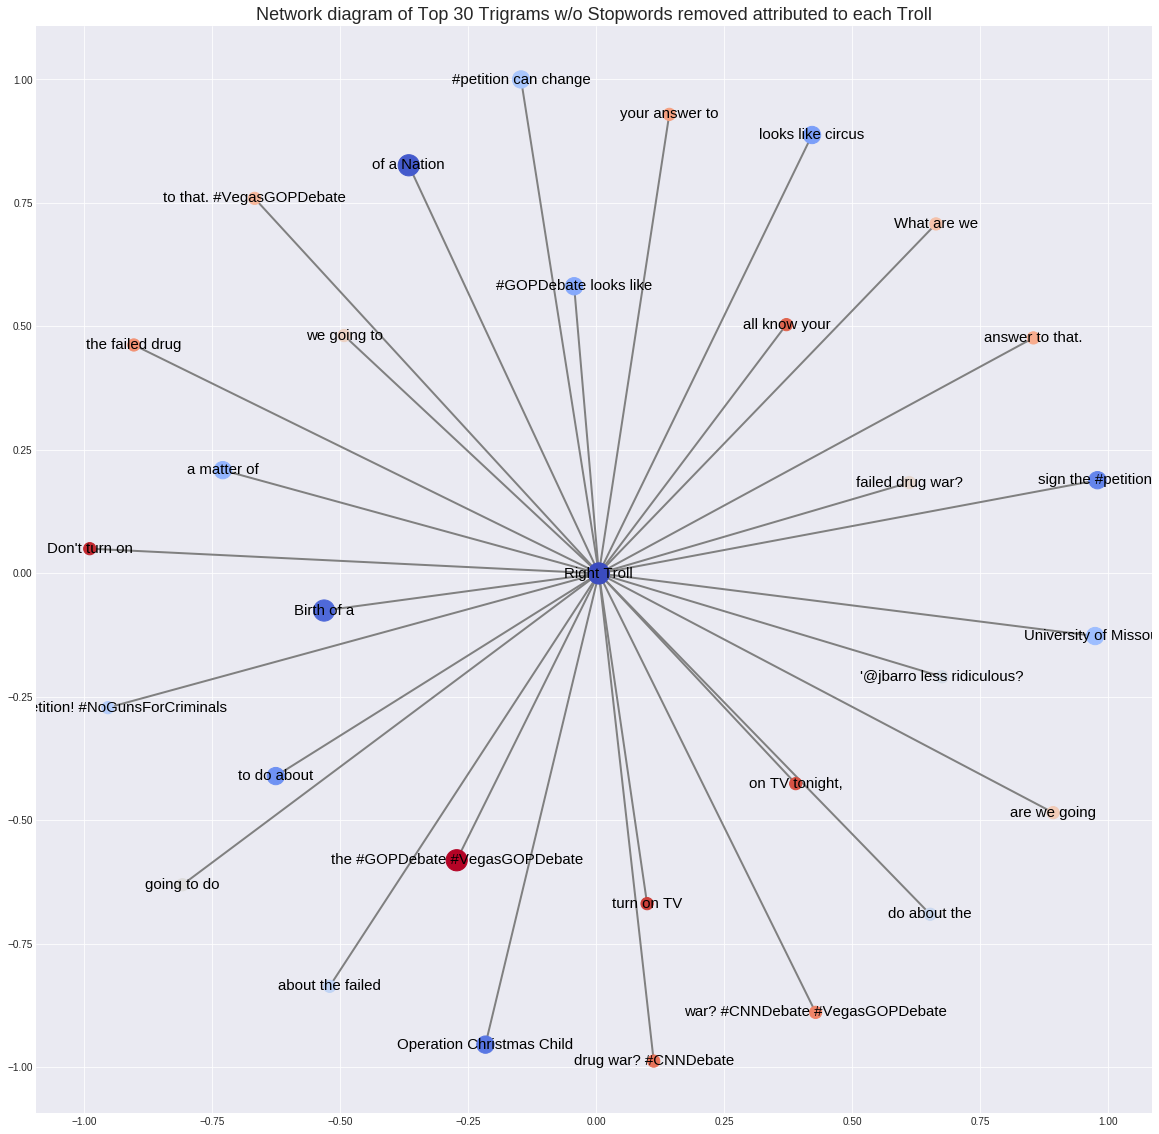

In [0]:
plt.figure(figsize=(20, 20))
cmap = plt.cm.coolwarm
colors = [n for n in range(len(g.nodes()))]
#k = 0.0319
k = 0.14
pos=nx.spring_layout(g, k=k)
nx.draw_networkx(g,pos, node_size=trigram_df['count'].values*150, cmap = cmap, 
                 node_color=colors, edge_color='grey', font_size=15, width=2, alpha=1)
plt.title("Network diagram of Top 30 Trigrams w/o Stopwords removed attributed to each Troll",
         fontsize=18)
plt.show()